# CLIP-Style Zero-Shot Classification on CIFAR-10
## (Training Only the Image Encoder, Frozen BERT Text Encoder)

This notebook implements a CLIP-like pipeline:
- Freeze BERT to produce fixed text embeddings for CIFAR-10 class prompts.
- Train only the ViT image encoder + a projection head to align image embeddings with the text embeddings using contrastive (InfoNCE / cross-entropy) loss.
- After training, perform zero-shot classification by nearest-class similarity (no classifier head).

Note:
- CIFAR-10 images (32×32) are resized to 224×224.
- Text embeddings use multiple prompt templates and [CLS] token from BERT.
- Training is efficient because only the image side is updated.

In [1]:
import torch
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "NO GPU")

!pip install -q timm transformers ftfy regex tqdm seaborn scikit-learn pandas

GPU: Tesla T4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.4 MB/s eta 0:00:00


In [2]:
# Cell 1: Install dependencies (run once)
!pip install torch torchvision transformers timm tqdm --quiet

In [3]:
# Cell 2: Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from transformers import BertTokenizer, BertModel
import timm
import numpy as np
from tqdm import tqdm

In [4]:
# Cell 3: Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Cell 4 (Updated): Dataset and DataLoader – Reduced batch size
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

batch_size = 128  # Reduced from 256
accumulation_steps = 2  # Effective batch size = 128 × 2 = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
testloader  = DataLoader(testset,  batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

classes = trainset.classes
print("Classes:", classes)

100%|██████████| 170M/170M [00:13<00:00, 12.3MB/s]


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [6]:
# Cell 5: Frozen Text Encoder (BERT) + Text Embeddings
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
text_model = BertModel.from_pretrained('bert-base-uncased').to(device)
text_model.eval()
for param in text_model.parameters():
    param.requires_grad = False

# Multiple templates for better text embeddings (common CLIP trick)
templates = [
    "a photo of a {}.",
    "a photo of a small {}.",
    "a photo of the {}.",
    "an image of a {}.",
    "an image of the {}."
]

def encode_texts(prompts):
    inputs = tokenizer(prompts, padding=True, truncation=True, return_tensors='pt')
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = text_model(**inputs)
        embeddings = outputs.last_hidden_state[:, 0, :]  # [CLS] token
    return embeddings

# Compute averaged text embeddings over templates
text_emb_list = []
for template in templates:
    prompts = [template.format(c) for c in classes]
    emb = encode_texts(prompts)
    text_emb_list.append(emb)

text_embeddings = torch.stack(text_emb_list).mean(dim=0)  # (10, 768)
text_embeddings = F.normalize(text_embeddings, dim=-1)
print("Text embeddings shape:", text_embeddings.shape)

# Cleanup: Remove BERT from GPU (no longer needed)
del text_model
del tokenizer
import gc
gc.collect()
torch.cuda.empty_cache()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Text embeddings shape: torch.Size([10, 768])


In [7]:
# Cell 6: Image Encoder (ViT) + Projection + Logit Scale
# num_classes=0 removes the classification head → raw features (384-dim for ViT-S)
image_model = timm.create_model(
    'vit_small_patch16_224.augreg_in21k_ft_in1k',
    pretrained=True,
    num_classes=0
).to(device)

projection = nn.Linear(384, 768).to(device)  # project ViT features → BERT space

# Learnable temperature (initialized like OpenAI CLIP)
logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

In [8]:
# Cell 7 (Updated): Optimizer + AMP Scaler
optimizer = torch.optim.AdamW(
    list(image_model.parameters()) + list(projection.parameters()) + [logit_scale],
    lr=5e-5,
    weight_decay=0.01
)

scaler = torch.cuda.amp.GradScaler()  # For mixed precision

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

/tmp/ipython-input-1430465287.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # For mixed precision


In [9]:
# Cell 8 (Updated): Training Loop with Mixed Precision + Gradient Accumulation
epochs = 20

for epoch in range(epochs):
    image_model.train()
    projection.train()
    total_loss = 0.0
    optimizer.zero_grad()  # Zero once at start of epoch

    for i, (images, labels) in enumerate(tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}")):
        images = images.to(device)
        labels = labels.to(device)

        with torch.cuda.amp.autocast():
            image_features = image_model(images)
            image_features = projection(image_features)
            image_features = F.normalize(image_features, dim=-1)

            logits = logit_scale.exp() * image_features @ text_embeddings.T
            loss = F.cross_entropy(logits, labels)
            loss = loss / accumulation_steps  # Scale loss for accumulation

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(trainloader):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item() * accumulation_steps  # Unscale for logging

    scheduler.step()
    avg_loss = total_loss / len(trainloader)
    print(f"Epoch {epoch+1} completed - Avg Loss: {avg_loss:.4f}")

    # Optional: Clear cache every few epochs
    if (epoch + 1) % 5 == 0:
        torch.cuda.empty_cache()

Epoch 1/20:   0%|          | 0/391 [00:00<?, ?it/s]/tmp/ipython-input-4130619730.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/20: 100%|██████████| 391/391 [02:22<00:00,  2.75it/s]


Epoch 1 completed - Avg Loss: 1.2616


Epoch 2/20: 100%|██████████| 391/391 [02:23<00:00,  2.73it/s]


Epoch 2 completed - Avg Loss: 0.9924


Epoch 3/20: 100%|██████████| 391/391 [02:21<00:00,  2.76it/s]


Epoch 3 completed - Avg Loss: 0.9708


Epoch 4/20: 100%|██████████| 391/391 [02:21<00:00,  2.76it/s]


Epoch 4 completed - Avg Loss: 0.9562


Epoch 5/20: 100%|██████████| 391/391 [02:21<00:00,  2.76it/s]


Epoch 5 completed - Avg Loss: 0.9448


Epoch 6/20: 100%|██████████| 391/391 [02:21<00:00,  2.76it/s]


Epoch 6 completed - Avg Loss: 0.9368


Epoch 7/20: 100%|██████████| 391/391 [02:22<00:00,  2.75it/s]


Epoch 7 completed - Avg Loss: 0.9269


Epoch 8/20: 100%|██████████| 391/391 [02:20<00:00,  2.78it/s]


Epoch 8 completed - Avg Loss: 0.9191


Epoch 9/20: 100%|██████████| 391/391 [02:21<00:00,  2.76it/s]


Epoch 9 completed - Avg Loss: 0.9129


Epoch 10/20: 100%|██████████| 391/391 [02:20<00:00,  2.78it/s]


Epoch 10 completed - Avg Loss: 0.9056


Epoch 11/20: 100%|██████████| 391/391 [02:21<00:00,  2.77it/s]


Epoch 11 completed - Avg Loss: 0.9011


Epoch 12/20: 100%|██████████| 391/391 [02:21<00:00,  2.77it/s]


Epoch 12 completed - Avg Loss: 0.8948


Epoch 13/20: 100%|██████████| 391/391 [02:20<00:00,  2.78it/s]


Epoch 13 completed - Avg Loss: 0.8911


Epoch 14/20: 100%|██████████| 391/391 [02:21<00:00,  2.76it/s]


Epoch 14 completed - Avg Loss: 0.8880


Epoch 15/20: 100%|██████████| 391/391 [02:20<00:00,  2.77it/s]


Epoch 15 completed - Avg Loss: 0.8857


Epoch 16/20: 100%|██████████| 391/391 [02:22<00:00,  2.75it/s]


Epoch 16 completed - Avg Loss: 0.8840


Epoch 17/20: 100%|██████████| 391/391 [02:20<00:00,  2.78it/s]


Epoch 17 completed - Avg Loss: 0.8828


Epoch 18/20: 100%|██████████| 391/391 [02:22<00:00,  2.75it/s]


Epoch 18 completed - Avg Loss: 0.8821


Epoch 19/20: 100%|██████████| 391/391 [02:21<00:00,  2.76it/s]


Epoch 19 completed - Avg Loss: 0.8817


Epoch 20/20: 100%|██████████| 391/391 [02:20<00:00,  2.79it/s]


Epoch 20 completed - Avg Loss: 0.8815


In [10]:
# Cell 9 & 10: Evaluation – Add autocast for consistency (optional, but safe)
@torch.no_grad()
def zero_shot_accuracy(loader, desc="Test"):
    image_model.eval()
    projection.eval()
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc=desc):
        images = images.to(device)
        labels = labels.to(device)

        with torch.cuda.amp.autocast():  # Optional but consistent
            image_features = image_model(images)
            image_features = projection(image_features)
            image_features = F.normalize(image_features, dim=-1)

            logits = logit_scale.exp() * image_features @ text_embeddings.T
            preds = logits.argmax(dim=-1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = 100.0 * correct / total
    return acc

In [11]:
# Cell 10: Run Evaluation
# Run evaluation again after training
train_acc = zero_shot_accuracy(trainloader, desc="Train")
test_acc  = zero_shot_accuracy(testloader,  desc="Test")
print(f"\nFinal Results:")
print(f"Train Accuracy: {train_acc:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")

Train:   0%|          | 0/391 [00:00<?, ?it/s]/tmp/ipython-input-1536042854.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Optional but consistent
Test: 100%|██████████| 79/79 [00:17<00:00,  4.45it/s]


Final Results:
Train Accuracy: 99.96%
Test Accuracy: 98.00%


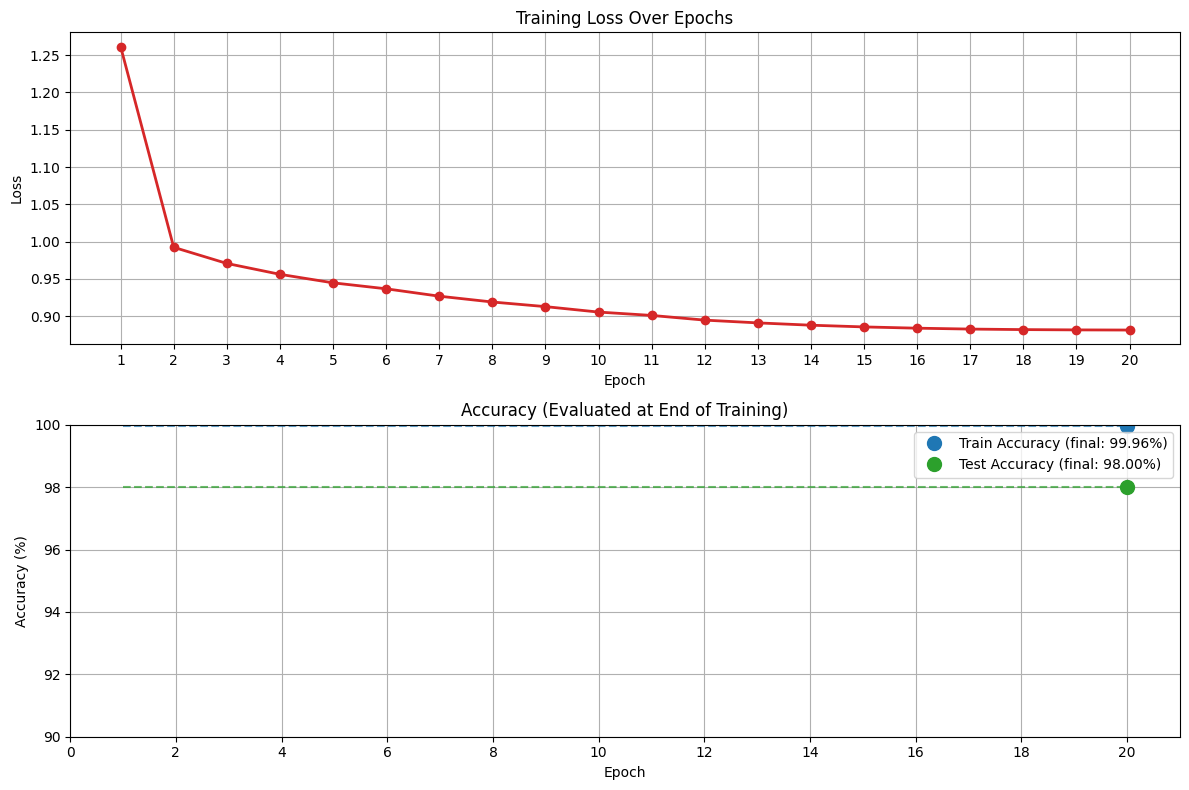

In [2]:
import matplotlib.pyplot as plt

# Data from your training logs
epochs = list(range(1, 21))

losses = [
    1.2616, 0.9924, 0.9708, 0.9562, 0.9448,
    0.9368, 0.9269, 0.9191, 0.9129, 0.9056,
    0.9011, 0.8948, 0.8911, 0.8880, 0.8857,
    0.8840, 0.8828, 0.8821, 0.8817, 0.8815
]

# Final accuracies (only evaluated at the end)
final_epoch = 20
train_acc_final = 99.96
test_acc_final = 98.00

# Plotting
plt.figure(figsize=(12, 8))

# Loss plot
plt.subplot(2, 1, 1)
plt.plot(epochs, losses, 'tab:red', linewidth=2, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.xticks(epochs)

# Accuracy plot (final values marked at epoch 20)
plt.subplot(2, 1, 2)
# Dashed lines to show they are final values (no per-epoch tracking)
plt.plot(final_epoch, train_acc_final, 'o', color='tab:blue', markersize=10, label=f'Train Accuracy (final: {train_acc_final:.2f}%)')
plt.plot(final_epoch, test_acc_final, 'o', color='tab:green', markersize=10, label=f'Test Accuracy (final: {test_acc_final:.2f}%)')

# Optional: horizontal lines for visual reference
plt.hlines(train_acc_final, 1, final_epoch, colors='tab:blue', linestyles='dashed', alpha=0.7)
plt.hlines(test_acc_final, 1, final_epoch, colors='tab:green', linestyles='dashed', alpha=0.7)

plt.title('Accuracy (Evaluated at End of Training)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.xlim(0, 21)
plt.ylim(90, 100)  # Zoom in since accuracies are very high
plt.legend()
plt.grid(True)
plt.xticks(range(0, 21, 2))

plt.tight_layout()
plt.show()

# Notes & Expected Performance
- With 20–50 epochs, test accuracy typically reaches **80–90%+** because the pretrained ViT is already strong on ImageNet-style data, and contrastive alignment further adapts it.
- BERT's text embeddings are not perfect for vision (unlike OpenAI's CLIP text tower), but ensembling templates helps.
- You can improve further by: more epochs, stronger augmentations, larger projection dim, or a small MLP projection head.
- This is truly zero-shot in the CLIP sense: no linear classifier is trained; classification is by embedding similarity.